<a href="https://colab.research.google.com/github/romauligraciella/EFCMvsDEC/blob/main/efcm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Restart session setelah install
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
import joblib
from tqdm import tqdm
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/SKRIPSI/'

# Model Word2Vec
import gensim
w2v_model = gensim.models.Word2Vec.load(path + "w2v-model/w2v-model.bin")

# Model DEC (Xie et. al)
import sys
sys.path.append('/content/drive/MyDrive/SKRIPSI/')
from DEC import DEC
from fcmeans import fcmeans

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/SKRIPSI/')
from fcmeans import fcmeans

In [ ]:
print(DEC)
print(fcmeans)

<class 'DEC.DEC'>
<function fcmeans at 0x7edc154028e0>


In [ ]:
import pandas as pd
dataset = pd.read_csv(path + 'data_MobileJKN .csv', usecols=['text_1', 'text_2', 'label'])

# Representasi dengan BERT

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
import joblib
from tqdm import tqdm
import os

def encode_text_bert(input_tokens, data_name, batch_size=128):

    save_dir = path + 'embedding'
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f'{data_name}_BERT.pkl')

    if os.path.exists(save_path):
        print(f"Loading existing BERT embedding from {save_path}")
        return joblib.load(save_path)

    model = TFAutoModel.from_pretrained('indobenchmark/indobert-base-p2')

    all_outputs = []
    for i in tqdm(range(0, len(input_tokens['input_ids']), batch_size)):
        batch = {k: v[i:i+batch_size] for k, v in input_tokens.items()}
        outputs = model(batch)
        pooled_output = tf.reduce_mean(outputs.last_hidden_state, axis=1)
        all_outputs.append(pooled_output)

    final_output = tf.concat(all_outputs, axis=0)
    joblib.dump(final_output, save_path)
    return final_output

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
tokens = tokenizer(dataset['text_1'].tolist(), return_tensors='tf',
                   truncation=True, padding=True, max_length=128)
emb = encode_text_bert(tokens, 'MobileJKN')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loading existing BERT embedding from /content/drive/MyDrive/SKRIPSI/embedding/MobileJKN_BERT.pkl


## Deep Autoencoder

In [ ]:
def DAE(data, low_dim):
    vocab_size=data.shape[1]

    # Layer 1
    input_ae = Input(shape = (vocab_size, ))
    dropped_in1 = Dropout(0.2)(input_ae)
    encoded1 = Dense(500, activation = 'relu')(dropped_in1)
    dropped_out1 = Dropout(0.2)(encoded1)
    decoded1 = Dense(vocab_size)(dropped_out1)

    autoencoder1 = Model(input_ae, decoded1)
    encoder1 = Model(input_ae, encoded1)

    # Layer 2
    encoded1_in = Input(shape = (500,))
    dropped_in2 = Dropout(0.2)(encoded1_in)
    encoded2 = Dense(500, activation = 'relu')(dropped_in2)
    dropped_out2 = Dropout(0.2)(encoded2)
    decoded2 = Dense(500, activation = 'relu')(dropped_out2)

    autoencoder2 = Model(encoded1_in,decoded2)
    encoder2 = Model(encoded1_in,encoded2)

    # Layer 3
    encoded2_in = Input(shape = (500,))
    dropped_in3 = Dropout(0.2)(encoded2_in)
    encoded3 = Dense(2000, activation = 'relu')(dropped_in3)
    dropped_out3 = Dropout(0.2)(encoded3)
    decoded3 = Dense(500, activation = 'relu')(dropped_out3)

    autoencoder3 = Model(encoded2_in,decoded3)
    encoder3 = Model(encoded2_in,encoded3)

    # Layer 4
    encoded3_in = Input(shape = (2000,))
    dropped_in4 = Dropout(0.2)(encoded3_in)
    encoded4 = Dense(low_dim)(dropped_in4)
    dropped_out4 = Dropout(0.2)(encoded4)
    decoded4 = Dense(2000, activation = 'relu')(dropped_out4)

    autoencoder4 = Model(encoded3_in,decoded4)
    encoder4 = Model(encoded3_in,encoded4)

    # Deep Autoencoder (𝑑−500−500−2000−10−2000−500−500−𝑑)
    encoder_layer1 = Dense(500, activation='relu')(input_ae)
    encoder_layer2 = Dense(500, activation='relu')(encoder_layer1)
    encoder_layer3 = Dense(2000, activation='relu')(encoder_layer2)
    latent = Dense(low_dim)(encoder_layer3)
    decoder_layer1 = Dense(2000, activation='relu')(latent)
    decoder_layer2 = Dense(500, activation='relu')(decoder_layer1)
    decoder_layer3 = Dense(500, activation='relu')(decoder_layer2)
    output_ae = Dense(vocab_size)(decoder_layer3)

    autoencoder = Model(input_ae,output_ae)
    encoder = Model(input_ae,latent)

    input_dcd = Input(shape=(low_dim,))
    decode_3 = autoencoder.layers[-4](input_dcd)
    decode_2 = autoencoder.layers[-3](decode_3)
    decode_1 = autoencoder.layers[-2](decode_2)
    output_dcd = autoencoder.layers[-1](decode_1)

    decoder = Model(input_dcd, output_dcd)

    cb = []
    opt = 'adam'
    earlystopping = EarlyStopping(monitor ="val_loss", patience = 10, restore_best_weights = True)
    cb.append(earlystopping)

    #compile semua model
    autoencoder1.compile(optimizer=opt, loss='mse')
    autoencoder2.compile(optimizer=opt, loss='mse')
    autoencoder3.compile(optimizer=opt, loss='mse')
    autoencoder4.compile(optimizer=opt, loss='mse')

    autoencoder.compile(optimizer=opt, loss='mse')

    #training
    print('Training layer by layer...\n')
    autoencoder1.fit(data, data, epochs=50, batch_size=256, validation_split = 0.1, callbacks=cb)
    print('1st layer trained.\n')
    first_layer_code = encoder1.predict(data)

    autoencoder2.fit(first_layer_code, first_layer_code, epochs=50, batch_size=256, validation_split = 0.1,
                     callbacks=cb, verbose=1)
    second_layer_code = encoder2.predict(first_layer_code)
    print('2nd layer trained.\n')

    autoencoder3.fit(second_layer_code, second_layer_code, epochs=50, batch_size=256, validation_split = 0.1,
                     callbacks=cb, verbose=1)
    print('3rd layer trained.\n')
    third_layer_code = encoder3.predict(second_layer_code)

    autoencoder4.fit(third_layer_code, third_layer_code, epochs=50, batch_size=256, validation_split = 0.1,
                     callbacks=cb, verbose=1)
    print('4th layer trained.\n')

    autoencoder.layers[1].set_weights(autoencoder1.layers[2].get_weights())
    autoencoder.layers[2].set_weights(autoencoder2.layers[2].get_weights())
    autoencoder.layers[3].set_weights(autoencoder3.layers[2].get_weights())
    autoencoder.layers[4].set_weights(autoencoder4.layers[2].get_weights())
    autoencoder.layers[5].set_weights(autoencoder4.layers[4].get_weights())
    autoencoder.layers[6].set_weights(autoencoder3.layers[4].get_weights())
    autoencoder.layers[7].set_weights(autoencoder2.layers[4].get_weights())
    autoencoder.layers[8].set_weights(autoencoder1.layers[4].get_weights())

    print('Training the whole autoencoder...\n')
    autoencoder_train = autoencoder.fit(data, data, epochs=100, batch_size=256, validation_split = 0.1, callbacks=cb, verbose=1)
    autoencoder_train
    print('Finished.\n')

    return autoencoder, encoder, decoder

## c-TF-IDF

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Class Based TFIDF
def tf_idf_count(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    tf_idf_top_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words, tf_idf_top_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "text": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

def c_tf_idf(docs_per_topic, m, n_words=10, n_gram_range=(1,1)):
    tf_idf, count = tf_idf_count(docs_per_topic.text.values, m=m)
    #top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, n_words)
    top_words, tf_idf_top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, n_words)
    return tf_idf, count, top_words, tf_idf_top_words

## Word2Vec

In [ ]:
# Nilai Coherence
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):

        pair_scores = []
        for i in range(len(term_rankings[topic_index])):
            for j in range(i + 1, len(term_rankings[topic_index])):
                term_i = term_rankings[topic_index][i]
                term_j = term_rankings[topic_index][j]
                if term_i in w2v_model.wv.key_to_index and term_j in w2v_model.wv.key_to_index:
                    pair_scores.append(w2v_model.wv.similarity(term_i, term_j))

        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score

    return overall_coherence / len(term_rankings)

# BERT-EFCM-cTFIDF

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.models import Model

def BERT_EFCM_cTFIDF(df, data_name, n_clusters, m=1.1, n_words=10, n_gram_range=(1,1)):

    # BERT
    print('Creating Text Embedding using BERT...')
    emb = encode_text_bert(tokens, data_name='MobileJKN')

    # EFCM
    print('Training EFCM...')
    svd = TruncatedSVD(n_components = 5)
    emb_tsvd = svd.fit_transform(emb)

    initkm = KMeans(n_clusters=n_clusters, n_init=1).fit(emb_tsvd)
    cntr, u = fcmeans(emb_tsvd.T, n_clusters, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
    cluster_membership = np.argmax(u, axis=0)

    # cTFIDF
    print('Extracting top words using cTFIDF')
    docs_df = df[['text_2']].copy()
    docs_df.rename({'text_2': 'text'}, axis=1, inplace=True)

    docs_df['topic'] = cluster_membership.reshape(-1,1)

    docs_df['doc_id'] = range(len(docs_df))

    docs_per_topic = docs_df.dropna(subset=['text']).groupby(['topic'], as_index = False).agg({'text': ' '.join})

    c_tf_idf_, count, top_words, top_words_c_tf_idf = c_tf_idf(docs_per_topic, docs_df.shape[0],
                                                              n_words=n_words, n_gram_range=n_gram_range)

    print('FINISHED')

    return emb, emb_tsvd, cluster_membership, c_tf_idf_, count, top_words, top_words_c_tf_idf

# Simulasi EFCM

In [ ]:
for m in np.arange(1.05, 3.51, 0.05):
  print('='*100)
  print('Fuzziness:', round(m, 2))
  tc_w2v = []
  best_tc_w2v = 0
  for n_topic in range(1, 11):
    print('='*100)
    print('TOPIC:', n_topic)
    tc_w2v_sim = []
    best_tc_w2v_sim = 0
    for sim in range(10):
      print('='*100)
      print('SIMULATION:', sim+1)
      print('='*100)
      emb_, emb_tsvd_, cluster_member_, c_tf_idf_, count_, top_words_, top_words_c_tf_idf_ = BERT_EFCM_cTFIDF(dataset,
                                                                                                              m=round(m, 2),
                                                                                                              data_name='MobileJKN',
                                                                                                              n_clusters=n_topic)
      tc_w2v_sim.append(calculate_coherence(w2v_model, top_words_))

      if best_tc_w2v_sim < calculate_coherence(w2v_model, top_words_):
        best_tc_w2v_sim = calculate_coherence(w2v_model, top_words_)

        best_emb_tsvd_sim, best_cluster_member_sim, best_c_tf_idf_sim, best_count_sim,\
        best_top_words_sim, best_top_words_ctfidf_sim = emb_tsvd_, cluster_member_, c_tf_idf_, count_, top_words_, top_words_c_tf_idf_

      print('='*100)
      print(f'FINISHED; {n_topic} TOPICS; SIMULATION {sim+1}; TC-W2V {round(tc_w2v_sim[-1], 3)}')
      print(f'BEST CURRENT TC-W2V: {best_tc_w2v_sim}; TOP WORDS: {best_top_words_sim}')

      os.makedirs(path + 'EFCM/tc_w2v', exist_ok=True)
      joblib.dump(tc_w2v_sim, f'{path}EFCM/tc_w2v/temp_tc_w2v_topic{n_topic}_m{round(m, 2)}.pkl')

    tc_w2v.append(tc_w2v_sim)

    if best_tc_w2v < np.array(tc_w2v_sim).mean():
      best_tc_w2v = np.array(tc_w2v_sim).mean()

      best_emb_tsvd, best_cluster_member, best_c_tf_idf, best_count,\
      best_top_words, best_top_words_ctfidf = best_emb_tsvd_sim, best_cluster_member_sim, best_c_tf_idf_sim, best_count_sim,\
                                              best_top_words_sim, best_top_words_ctfidf_sim
      best_n_topic = n_topic

      bests = (best_emb_tsvd, best_c_tf_idf, best_count, best_top_words, best_top_words_ctfidf)

      joblib.dump(bests, f'{path}EFCM/best_emb_tsvd_ctfidf_count_topwords_topic{n_topic}_m{round(m, 2)}.pkl')

    print('-'*100)
    print(f'FINISHED; {n_topic} TOPICS ALL SIMULATION; TC-W2V mean {np.array(tc_w2v_sim).mean()}')
    print(f'BEST N TOPICS: {best_n_topic}; BEST TC-W2V: {best_tc_w2v}; BEST TOP WORDS: {best_top_words}')
    print('-'*100)

    os.makedirs(path + 'EFCM/tc_w2v', exist_ok=True)
    joblib.dump(tc_w2v, f'{path}EFCM/tc_w2v/temp_tc_w2v_m{round(m, 2)}.pkl')

joblib.dump(tc_w2v, path + 'EFCM/tc_w2v/simulasi_tc_w2v_m{round(m, 2)}.pkl')

Streaming output truncated to the last 5000 lines.
----------------------------------------------------------------------------------------------------
FINISHED; 7 TOPICS ALL SIMULATION; TC-W2V mean 0.20810196075114917
BEST N TOPICS: 2; BEST TC-W2V: 0.2283475737915271; BEST TOP WORDS: [['bpjs', 'membantu', 'jkn', 'mudah', 'aplikasi', 'mobile', 'pelayanan', 'kesehatan', 'faskes', 'bagus'], ['update', 'daftar', 'aplikasi', 'login', 'masuk', 'verifikasi', 'susah', 'kode', 'otp', 'nomor']]
----------------------------------------------------------------------------------------------------
TOPIC: 8
SIMULATION: 1
Creating Text Embedding using BERT...
Loading existing BERT embedding from /content/drive/MyDrive/SKRIPSI/embedding/MobileJKN_BERT.pkl
Training EFCM...
Extracting top words using cTFIDF
FINISHED
FINISHED; 8 TOPICS; SIMULATION 1; TC-W2V 0.215
BEST CURRENT TC-W2V: 0.21458463996199756; TOP WORDS: [['bpjs', 'daftar', 'aplikasi', 'jkn', 'nomor', 'pakai', 'mohon', 'verifikasi', 'login', '

['/content/drive/MyDrive/SKRIPSI/EFCM/tc_w2v/simulasi_tc_w2v_m{round(m, 2)}.pkl']

# efcm

In [ ]:
import numpy as np

all_results = {}  # Dictionary untuk simpan semua hasil

for m in np.arange(1.05, 3.51, 0.05):
    m = round(m, 2)

    # Load kembali data coherence per m yang sudah disimpan sebelumnya
    tc_w2v = joblib.load(f'{path}EFCM/tc_w2v/temp_tc_w2v_m{m}.pkl')  # List [10 topics][10 simulations]

    # Langkah 1: Ambil rata-rata coherence dari 10 simulasi per topik
    mean_per_topic = [np.mean(sim_coherences) for sim_coherences in tc_w2v]  # hasilnya 10 nilai

    # Langkah 2: Ambil rata-rata akhir coherence dari semua topik
    mean_for_m = np.mean(mean_per_topic)  # satu nilai

    # Simpan hasil ke dictionary
    all_results[m] = {
        'mean_per_topic': mean_per_topic,
        'mean_for_m': mean_for_m
    }

# Ambil m terbaik (dengan rata-rata coherence tertinggi)
best_m = max(all_results, key=lambda x: all_results[x]['mean_for_m'])

print(f'\n>> Nilai m terbaik: {best_m} dengan rata-rata coherence: {all_results[best_m]["mean_for_m"]:.4f}')


>> Nilai m terbaik: 2.25 dengan rata-rata coherence: 0.2257


In [ ]:
import pandas as pd

# Buat list of dict untuk DataFrame
rows = []
for m, result in all_results.items():
    row = {'m': m}
    for topic_num, score in enumerate(result['mean_per_topic'], start=1):
        row[f'Topic_{topic_num}'] = score
    row['Mean_Coherence_All_Topics'] = result['mean_for_m']
    rows.append(row)

# Buat DataFrame
df = pd.DataFrame(rows)
df = df.sort_values(by='m').reset_index(drop=True)

# Tampilkan
df

,m,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Mean_Coherence_All_Topics
0,1.05,0.215108,0.221715,0.222584,0.228227,0.230795,0.229448,0.223532,0.221916,0.224838,0.227133,0.224530
1,1.10,0.215108,0.221715,0.222584,0.228227,0.230795,0.229206,0.223532,0.220726,0.224840,0.225722,0.224245
2,1.15,0.215108,0.221715,0.222584,0.228227,0.230795,0.229574,0.222901,0.221321,0.225245,0.225504,0.224297
3,1.20,0.215108,0.221715,0.222584,0.228227,0.230795,0.228913,0.222543,0.221417,0.227830,0.224531,0.224366
4,1.25,0.215108,0.221715,0.222584,0.228227,0.230795,0.228913,0.223400,0.222329,0.228370,0.225964,0.224740
5,1.30,0.215108,0.221715,0.222584,0.228227,0.230795,0.227060,0.223609,0.225046,0.227092,0.225364,0.224660
6,1.35,0.215108,0.221715,0.222584,0.228227,0.230795,0.227256,0.223402,0.224780,0.226288,0.226218,0.224637
7,1.40,0.215108,0.221715,0.222584,0.228227,0.230795,0.227192,0.223965,0.224853,0.225902,0.226176,0.224652
8,1.45,0.215108,0.221715,0.222584,0.228227,0.230795,0.227589,0.224440,0.223666,0.223454,0.225058,0.224264
9,1.50,0.215108,0.221715,0.222584,0.228227,0.230795,0.227335,0.224599,0.223050,0.222150,0.224302,0.223986


<ipython-input-14-c00eb8d49766>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


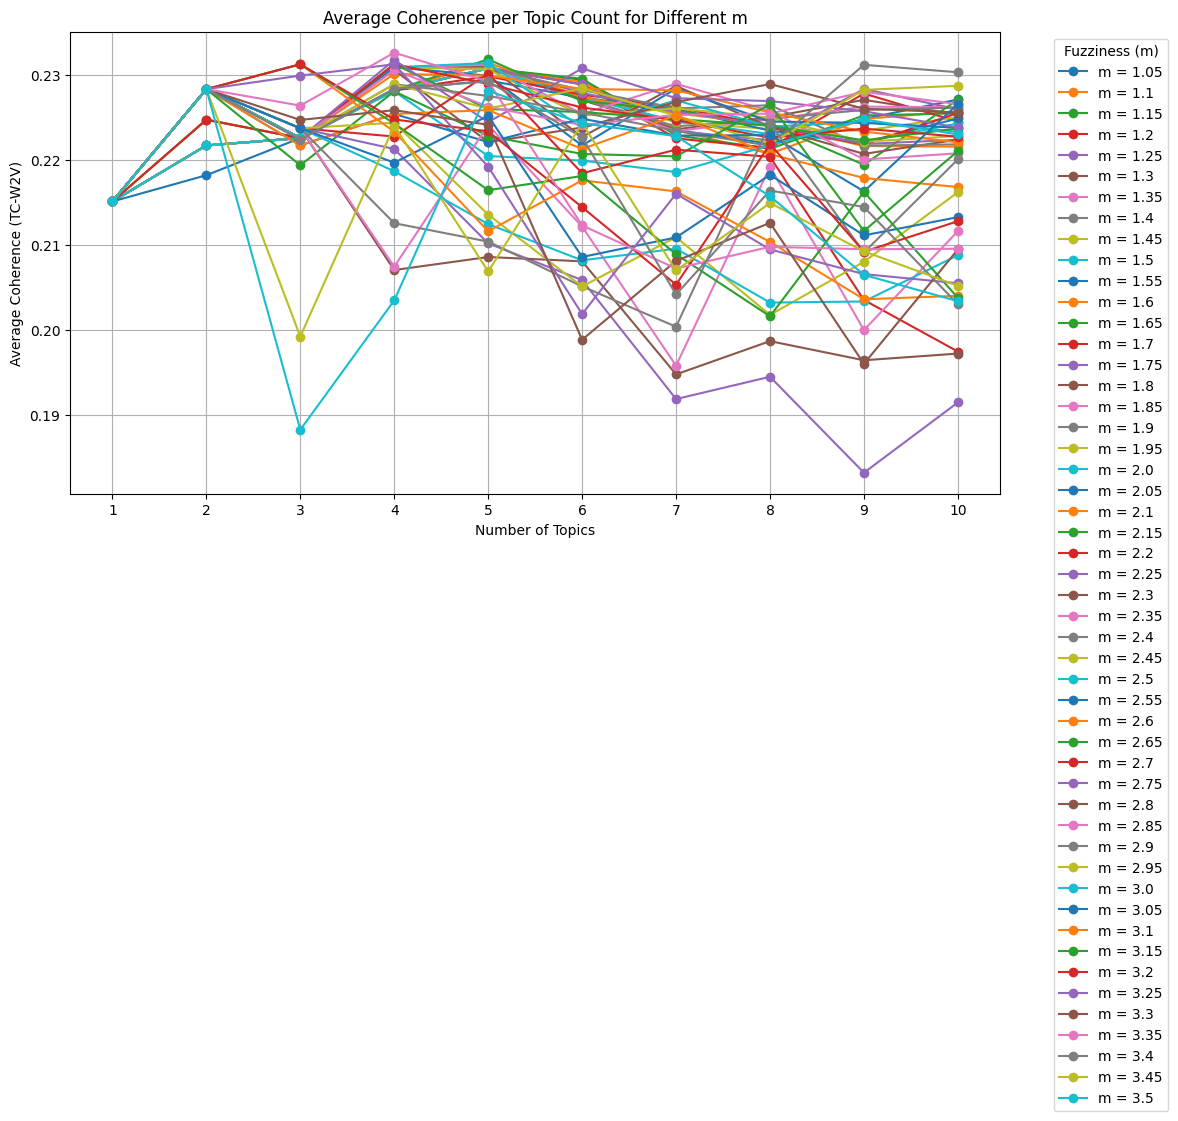

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Untuk setiap nilai m, buat satu garis
for m, result in sorted(all_results.items()):
    mean_per_topic = result['mean_per_topic']  # list dengan 10 angka
    plt.plot(range(1, 11), mean_per_topic, marker='o', label=f'm = {round(m, 2)}')

# Tambahan elemen grafik
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence (TC-W2V)')
plt.title('Average Coherence per Topic Count for Different m')
plt.xticks(range(1, 11))  # pastikan sumbu X = 1-10 topik
plt.grid(True)
plt.legend(title='Fuzziness (m)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




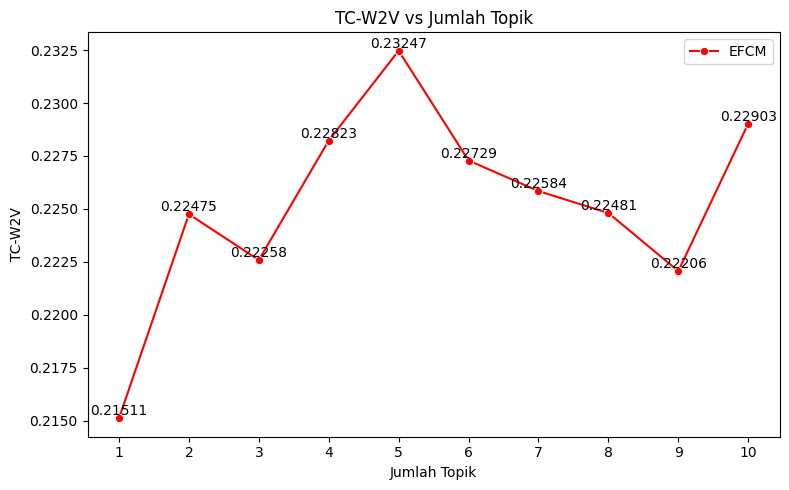

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

m_value = 1.65
tc_w2v_EFCM = joblib.load(f'{path}EFCM/tc_w2v/temp_tc_w2v_m{round(m_value, 2)}.pkl')

tc_w2v_EFCM = np.array(tc_w2v_EFCM)
tc_w2v_best_per_topic = tc_w2v_EFCM.max(axis=1)

# Siapkan data untuk plot
data = {
    'Jumlah Topik': np.arange(1, 11),
    'TC-W2V Terbaik': tc_w2v_best_per_topic
}

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(x='Jumlah Topik', y='TC-W2V Terbaik', data=data, marker='o', label='EFCM', color='red')

# Tampilkan nilai terbaik pada setiap titik
for x, y in zip(data['Jumlah Topik'], data['TC-W2V Terbaik']):
    plt.text(x, y, f'{y:.5f}', ha='center', va='bottom')

# Tambahkan judul dan label
plt.title('TC-W2V vs Jumlah Topik')
plt.xlabel('Jumlah Topik')
plt.ylabel('TC-W2V')
plt.xticks(np.arange(1, 11))

plt.tight_layout()
plt.show()


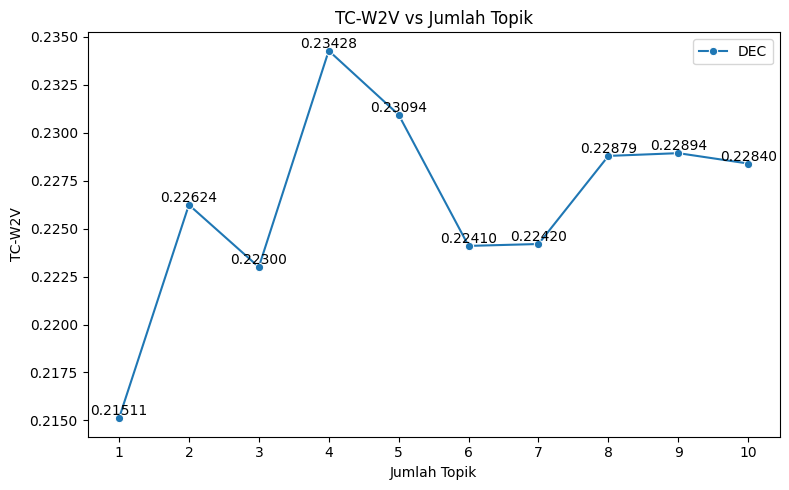

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

tc_w2v_DEC = []
for i in range(1, 11):
  tc_w2v_DEC.append(joblib.load(f'/content/drive/MyDrive/FIX_SKRIPSI/DEC/tc_w2v/temp_tc_w2v_topic{i}.pkl'))

# Define the data
data = {'Jumlah Topik': np.arange(1, 11),
        'TC-W2V DEC': np.array(tc_w2v_DEC).max(axis=1)}

# Create a Seaborn line plot
plt.figure(figsize=(8, 5))
sns.lineplot(x='Jumlah Topik', y='TC-W2V DEC', data=data, marker='o', label='DEC')

# Add text annotations for each data point
for x, y in zip(data['Jumlah Topik'], data['TC-W2V DEC']):
    plt.text(x, y, f'{y:.5f}', ha='center', va='bottom')

# Set the plot title and labels
plt.title('TC-W2V vs Jumlah Topik')
plt.xlabel('Jumlah Topik')
plt.ylabel('TC-W2V')
plt.xticks(np.arange(1, 11), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

# Show the plot
plt.tight_layout()
plt.show()

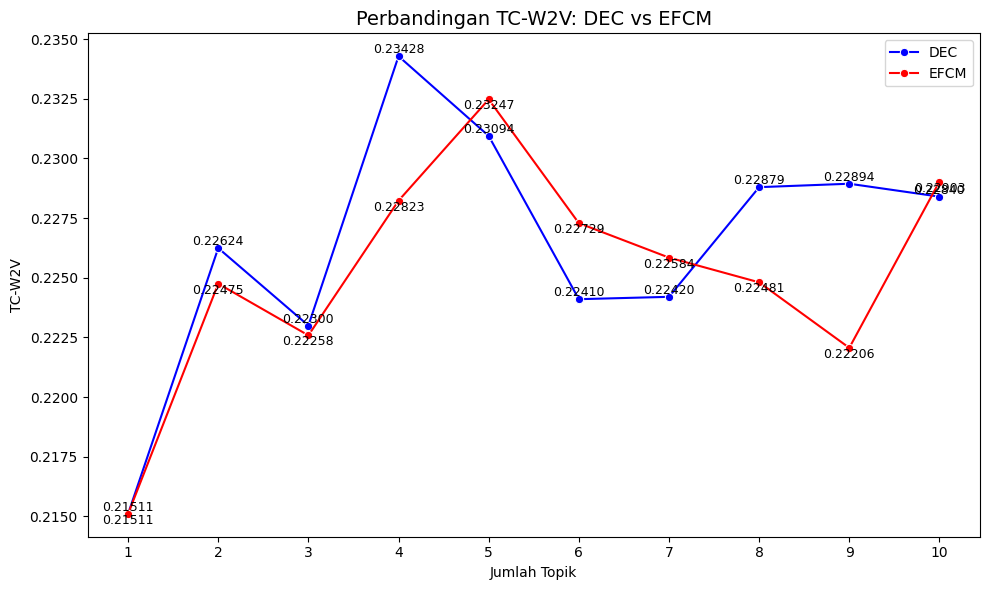

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# === Load data untuk DEC ===
tc_w2v_DEC = []
for i in range(1, 11):
    tc_w2v_DEC.append(joblib.load(f'/content/drive/MyDrive/FIX_SKRIPSI/DEC/tc_w2v/temp_tc_w2v_topic{i}.pkl'))

tc_w2v_DEC = np.array(tc_w2v_DEC)
tc_w2v_DEC_max = tc_w2v_DEC.max(axis=1)

# === Load data untuk EFCM ===
m_value = 1.65
tc_w2v_EFCM = joblib.load(f'{path}EFCM/tc_w2v/temp_tc_w2v_m{round(m_value, 2)}.pkl')

tc_w2v_EFCM = np.array(tc_w2v_EFCM)
tc_w2v_EFCM_max = tc_w2v_EFCM.max(axis=1)

# === Plot kedua garis ===
plt.figure(figsize=(10, 6))

# Plot untuk DEC
sns.lineplot(x=np.arange(1, 11), y=tc_w2v_DEC_max, marker='o', label='DEC', color='blue')
for x, y in zip(np.arange(1, 11), tc_w2v_DEC_max):
    plt.text(x, y, f'{y:.5f}', ha='center', va='bottom', fontsize=9)

# Plot untuk EFCM
sns.lineplot(x=np.arange(1, 11), y=tc_w2v_EFCM_max, marker='o', label='EFCM', color='red')
for x, y in zip(np.arange(1, 11), tc_w2v_EFCM_max):
    plt.text(x, y, f'{y:.5f}', ha='center', va='top', fontsize=9)

# === Judul dan label ===
plt.title('Perbandingan TC-W2V: DEC vs EFCM', fontsize=14)
plt.xlabel('Jumlah Topik')
plt.ylabel('TC-W2V')
plt.xticks(np.arange(1, 11))
plt.legend()

plt.tight_layout()
plt.show()


# Visualisasi T-SNE

In [ ]:
import joblib

m = 1.65
tc_w2v_all = joblib.load(f'{path}EFCM/tc_w2v/temp_tc_w2v_m{round(m, 2)}.pkl')
bests = joblib.load(f'{path}EFCM/best_emb_tsvd_ctfidf_count_topwords_topic5_m{round(m, 2)}.pkl')
best_emb_tsvd, best_c_tf_idf, best_count, best_top_words, best_top_words_ctfidf = bests

In [ ]:
best_top_words

[['kode',
  'login',
  'verifikasi',
  'masuk',
  'daftar',
  'nomor',
  'otp',
  'update',
  'aplikasi',
  'muncul'],
 ['bpjs',
  'jkn',
  'faskes',
  'mobile',
  'kantor',
  'kartu',
  'data',
  'daftar',
  'mohon',
  'peserta'],
 ['update',
  'susah',
  'aplikasi',
  'daftar',
  'masuk',
  'buka',
  'login',
  'ribet',
  'verifikasi',
  'bikin'],
 ['aplikasi',
  'daftar',
  'pakai',
  'update',
  'bikin',
  'susah',
  'masuk',
  'login',
  'verifikasi',
  'ribet'],
 ['membantu',
  'mudah',
  'pelayanan',
  'kesehatan',
  'bagus',
  'cepat',
  'semoga',
  'jkn',
  'memudahkan',
  'mobile']]

In [ ]:
m = 1.65
initkm = KMeans(n_clusters=5, n_init=20).fit(best_emb_tsvd)
cntr, u = fcmeans(best_emb_tsvd.T, 5, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership= np.argmax(u, axis=0)

In [ ]:
np.unique(cluster_membership)

array([0, 1, 2, 3, 4])

In [ ]:
print(best_emb_tsvd.shape)
print(cntr.shape)

(88844, 5)
(5, 5)


In [ ]:
np.append(best_emb_tsvd, cntr, axis=0).shape

(88849, 5)

In [ ]:
calculate_coherence(w2v_model, best_top_words)

0.23247128830187852

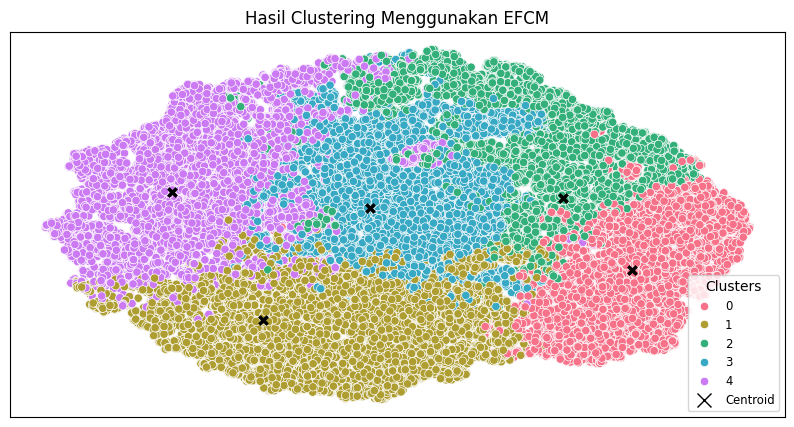

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.lines as mlines
unique_values = [0, 1, 2, 3, 4]
# Creating a custom color palette with distinct colors
custom_palette = sns.color_palette("husl", n_colors=len(unique_values))
# Creating a dictionary to map hue values to colors
hue_color_mapping = dict(zip(unique_values, custom_palette))

enc_mobilejkn_tsne = TSNE(2).fit_transform((np.append(best_emb_tsvd, cntr, axis=0)))

fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x=enc_mobilejkn_tsne[:-5,0], y=enc_mobilejkn_tsne[:-5,1], hue=cluster_membership,
                palette=hue_color_mapping, ax=ax)
sns.scatterplot(x=enc_mobilejkn_tsne[-5:,0], y=enc_mobilejkn_tsne[-5:,1],
                color='black', marker='x', linewidth=2.5, ax=ax)

handles, labels = ax.get_legend_handles_labels()
centroid_marker = mlines.Line2D([], [], color='black', marker='x', linewidth=1, linestyle='None', markersize=10, label='Centroid')



handles.append(centroid_marker)
labels.append('Centroid')
ax.legend(handles=handles, labels=labels, title='Clusters', fontsize='small', loc='lower right')

# Hide grid and axes
ax.grid(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title("Hasil Clustering Menggunakan EFCM")
plt.show()